In [214]:
# predict news data with bi-lstm
from pygooglenews import GoogleNews
from matplotlib.pyplot import table
from time import time
from datetime import date, datetime, timedelta
from keras.models import load_model
import gensim
import nltk.tokenize as tk
import numpy as np

def tokenizer(text):
    return tk.regexp_tokenize(text.lower(), r'[^a-zA-Z]+', gaps=True)


bi_lstm_model = load_model('bi-lstm.h5')

# get raw data
to_date = date.today().strftime('%Y-%m-%d')
gn = GoogleNews(lang='en')

tickers="TSLA"

# search query format
# "ticker stock" OR intitle: ticker
query = ""
query = query+ "\"" + tickers +" stock\" OR intitle: " + tickers 

titles = []
sources = []  # used for title cleaning
dates = []
# search articles day by day
for days_before in range(1, 30 ):
    from_date = date.today()-timedelta(days=days_before)
    to_date = date.today()-timedelta(days=(days_before-1))
    # articles in 30 days
    articles = gn.search(query,
                         from_=from_date.strftime('%Y-%m-%d'),
                         to_=to_date.strftime('%Y-%m-%d'))['entries']
    sources_size = len(sources)  # adjust data
    for entry in articles:
        sources.append(entry['source']['title'])  # name of source
        dates.append(from_date)
    for i in range(len(articles)):
        to_replace = articles[i]['title']
        # print(to_replace)
        # replace redundant substring
        replaced = to_replace.replace("- "+sources[i+sources_size], "")
        replaced_again = replaced.replace("- "+sources[i+sources_size], "")
        # print(replaced)
        titles.append(replaced_again)


In [215]:

# preprocess title & build word2vec
tokenized_sentences = []
for i in titles:
    tokenized_sentences.append(tokenizer(i))

max_length = 50


vec_model = gensim.models.Word2Vec(window=5,min_count=3) # each vector 100 dimension by default
vec_model.build_vocab(tokenized_sentences)
vec_model.train(tokenized_sentences,total_examples=vec_model.corpus_count,epochs=100)


X=[]
filler = [0 for i in range(100)]

for sentence in tokenized_sentences:
    word_vec=[] # each word has a word vector
    for word in sentence:
        if word in vec_model.wv:
            word_vec.append(vec_model.wv[word].tolist())
        else: word_vec.append(filler)
    # pad shorter sentence
    for shorter_amount in range((max_length-len(sentence))):
        word_vec.append(filler)
        
    # shape(word_vec) = (50,100)
    X.append(word_vec)
X = np.array(X,np.float64)

X.shape

(102, 50, 100)

In [216]:
import pandas as pd

prediction = bi_lstm_model.predict(X)
# 1 0 0 neutral
# 0 1 0 positive
# 0 0 1 negative
df = pd.DataFrame(prediction,columns=['neutral','positve','negative'])
df.head()

sentiments =[]
prediction.tolist()
for i in prediction:
    sentiments.append((i[1]-i[2]))

4/4 [==============================] - 1s 8ms/step


In [217]:
import numpy as np
import pandas as pd
table = np.array([dates, titles, sentiments])
news_df = pd.DataFrame(table.transpose(), columns=[
                       'Date', 'Title', 'Sentiment'])


In [218]:
news_df['Sentiment'] = pd.to_numeric(news_df['Sentiment'])
news_df = news_df.groupby('Date').mean()

news_df['MA'] = news_df.rolling(window=3).mean()
news_df


,Sentiment,MA
Date,,
2022-06-26,0.274897,NaN
2022-06-27,0.269980,NaN
2022-06-28,0.218065,0.254314
2022-06-29,0.263771,0.250605
2022-06-30,0.291086,0.257641
2022-07-01,0.267742,0.274200
2022-07-02,0.322772,0.293867
2022-07-05,0.270265,0.286926
2022-07-06,0.275132,0.289390


<AxesSubplot:xlabel='Date', ylabel='Close'>

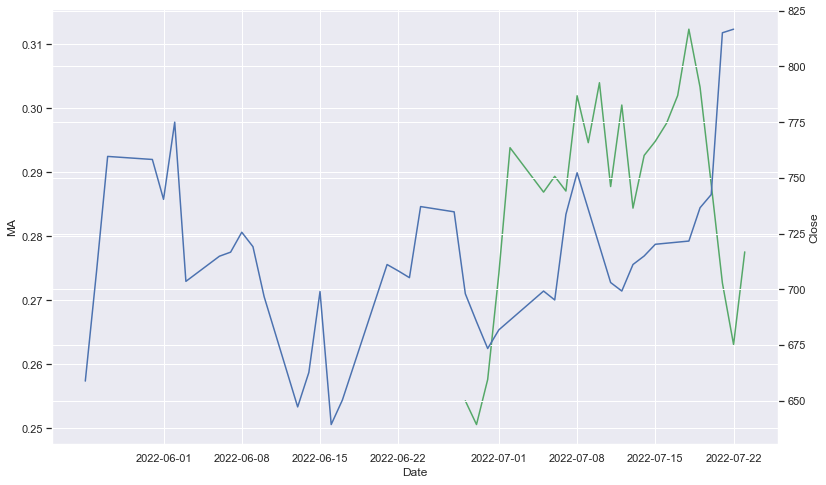

In [221]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc

import seaborn as sb
from pandas_datareader import data
start = datetime.today()-timedelta(days=60)
end = datetime.today()-timedelta(days=0)
source = "yahoo"
tickers = ["TSLA"]

stock_df = pd.concat([data.DataReader(t, source, start, end)
               for t in tickers]).reset_index()
dates = stock_df["Date"]
stock_df.head()
stock_df.set_index(stock_df['Date'],inplace=True)
sb.set(rc={'figure.figsize': (13.0, 8.0)})
ax = sb.lineplot(data=news_df['MA'],color='g')
ax2 = plt.twinx()
sb.lineplot(data=stock_df['Close'],ax=ax2)